In [1]:
import math
import os
import seaborn as sns
import random

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from math import ceil, floor
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.distributions import Normal
from scipy.stats import rv_discrete

In [2]:
def argmax(q_values):

    rand_generator = np.random.RandomState()

    top = float("-inf")
    ties = []

    for i in range(len(q_values)):
        if q_values[i] > top:
            top = q_values[i]
            ties = []

        if q_values[i] == top:
            ties.append(i)

    return rand_generator.choice(ties)

In [3]:
class Memory():
    
    def __init__(self):
        self.reset()
        self.all_rewards = []
    
    def reset(self):
        self.states = []
        self.actions = []
        self.log_probs = []
        self.mexs = []
        self.log_probs_mexs = []
        self.rewards = []
        
    def push(self, s, a, lp):
        self.states.append(s)        
        self.actions.append(a)        
        self.log_probs.append(lp)
        
    def push_comm(self, s, a, lp):
        self.states.append(s)        
        self.mexs.append(a)        
        self.log_probs_mexs.append(lp)
        
    def save_reward(self, r):
        self.rewards.append(r)        
        self.all_rewards.append(r)

In [4]:
class CommPolicy():
    def __init__(self, n_coins, n_players, lr=0.01):
        
        self.n_coins = n_coins
        self.n_players = n_players
        self.lr = lr
        self.n_actions = 2 # 0 non do soldi, 1 do soldi
        
        self.q = np.full((self.n_coins+1, self.n_actions), float(self.n_coins))
        
    def update(self, coin, mex, rew):
        #print("prima", self.q[coin, mex])
        #print("rew=", rew, "lr=", self.lr, "rew - self.q[coin, mex]=",rew - self.q[coin, mex])
        #print("self.lr*(rew - self.q[coin, mex])=", self.lr*(rew - self.q[coin, mex]))
        self.q[coin, mex] += self.lr*(rew - self.q[coin, mex])
        #print("dopo", self.q[coin, mex])

In [5]:
class SimpleActPolicy():
    def __init__(self, n_players, n_coins, lr=0.01):
        
        self.n_coins = n_coins
        self.n_players = n_players
        self.lr = lr
        self.n_actions = 2 # 0 non do soldi, 1 do soldi
        
        self.q = np.full((self.n_coins+1, self.n_actions), float(self.n_coins))
        
    def update(self, coin, act, rew):
        self.q[coin, act] += self.lr*(rew - self.q[coin, act])

In [6]:
class ActPolicy():
    def __init__(self, n_players, n_coins, lr=0.01):
        
        self.n_coins = n_coins
        self.n_players = n_players
        self.lr = lr
        self.n_actions = 2 # 0 non do soldi, 1 do soldi
        
        self.q = np.full((self.n_coins+1, self.n_players+1, self.n_actions), float(self.n_coins))
        
    def update(self, coin, mex, act, rew):
        self.q[coin, np.sum(mex), act] += self.lr*(rew - self.q[coin, np.sum(mex), act])

In [7]:
class Agent():
    def __init__(self, n_players, n_coins, episode_len, epsilon=0.01, n_actions=2, lr = 0.01, _gamma = 0.99):
        
        self.n_players = n_players
        self.n_coins = n_coins
        self.n_actions = n_actions # 0 non do soldi, 1 do soldi
        self.episode_len = episode_len

        self.comm_policy = CommPolicy(self.n_coins, self.n_players)
        self.act_policy = ActPolicy(self.n_players, self.n_coins)
        self.simple_act_policy = SimpleActPolicy(self.n_players, self.n_coins)
        
        self.epsilon = epsilon
        
        self._gamma = _gamma
        
        self.memory = Memory()
        
        self.reset()
        
    def reset(self):
        self.memory.reset()
    
    def act(self, coin, messages): 
        
        action = 0
        
        if np.random.rand() < self.epsilon:
            action = np.random.choice(2, 1)[0]
        else:
            action = argmax(self.act_policy.q[coin, np.sum(messages)])
            
        return int(action)
    
    def simple_act(self, coin):
        
        action = 0
        
        if np.random.rand() < self.epsilon:
            action = np.random.choice(2, 1)[0]
        else:
            action = argmax(self.simple_act_policy.q[coin])
            
        return int(action)

    def comm(self, coin):
        action = 0
        
        if np.random.rand() < self.epsilon:
            action = np.random.choice(2, 1)[0]
        else:
            action = argmax(self.comm_policy.q[coin])
            
        return int(action)
    
    def memorize(self, s, a, lp):
        self.memory.push(s, a, lp)
        
    def memorize_comm(self, s, a, lp):
        self.memory.push_comm(s, a, lp)
    
    def memorize_rewards(self, r):
        self.memory.save_reward(r)

In [8]:
class Environment:

    def __init__(self, n_players, n_total_coins, threshold = 0., multiplier = 1.):
        self.n_players = n_players
        self.n_total_coins = n_total_coins
        self.state = np.zeros((self.n_players,1))
        self.threshold = threshold
        self.multiplier = multiplier

    def reset(self):
        self.state = np.zeros(self.n_players)
        self.rews_dict = {k: [] for k in range(self.n_players)}
        
    def equal_division(self):
        self.coins = [int(self.n_total_coins/self.n_players) for i in range(self.n_players)]
        return self.coins
            
    def sample(self):
        left_coins = self.n_total_coins
        self.coins = []
        
        for i in range(self.n_players):
            if (i == self.n_players - 1):
                self.coins.append(left_coins)
            else:
                val = int(np.random.choice(left_coins-1, 1))
                self.coins.append(val)
                left_coins = left_coins - val 
                
        return self.coins
    
    def sample_2(self):
        
        containers = [[] for _ in range(self.n_players)]
        objects = [1 for _ in range(self.n_total_coins)]

        for object in objects:
            random.choice(containers).append(object)

        self.coins = [len(containers[i]) for i in range(self.n_players)]

        return self.coins

    def step(self, coins, actions):
        rewards = np.zeros(self.n_players)
        
        if (np.sum(actions)) < self.threshold:
            return rewards
        
        amount = np.sum([coins[i] for i in range(self.n_players) if actions[i] == 1])
            
        for i in range(self.n_players):
            if (actions[i] == 1.):
                rewards[i] = amount/self.n_players*self.multiplier
            else:
                rewards[i] = amount/self.n_players*self.multiplier + coins[i]
                
            # trick to avoid log(0) 
            if rewards[i] <= 0:
                rewards[i] = 1e-6

        return rewards
    
    def new_reward_function(self, coins, actions, old_rewards=None):
        rewards = np.zeros(self.n_players)
        penalty = -20
        
        amount = np.sum([coins[i] for i in range(self.n_players) if actions[i] == 1])
        
        for i in range(self.n_players):
            if (actions[i] == 1.):
                rewards[i] = amount/self.n_players*self.multiplier
            else:
                rewards[i] = amount/self.n_players*self.multiplier + coins[i]
        
            if (old_rewards is not None):
                if (rewards[i] <= 2 and old_rewards[i] <= 2):
                    rewards[i] += penalty
                

        return rewards

In [9]:
class System():
    
    def __init__(self, n_players, n_coins, episode_len, epsilon=0.01, n_actions=2, lr=0.01, _gamma=0.99):
        
        self.n_players = n_players
        self.n_coins = n_coins
        self.n_actions = n_actions # 0 non do soldi, 1 do soldi
        self.episode_len = episode_len
        self.lr = lr
        
        self.agents = {k: Agent(n_players, n_coins, episode_len=episode_len, epsilon=epsilon) for k in range(self.n_players)}

    def reset(self):
        for _, ag in self.agents.items(): ag.reset()
            
    def set_epsilon(self, e):
        for _, ag in self.agents.items(): ag.epsilon = e 
            
    def comm(self, coins):
        mexs = np.zeros(self.n_players).astype(int)
        
        for i, agent in self.agents.items():
            mexs[i] = int(agent.comm(coins[i]))
            
        return mexs
            
    def act(self, coins, mexs):
        actions = np.zeros(self.n_players).astype(int)
        
        for i, agent in self.agents.items():
            actions[i] = agent.act(coins[i], mexs)
           
        return actions
    
    def simple_act(self, coins):
        actions = np.zeros(self.n_players).astype(int)
        
        for i, agent in self.agents.items():
            actions[i] = agent.simple_act(coins[i])
           
        return actions
    
    def memorize_rewards(self, rews):
        for idx, ag in self.agents.items(): ag.memorize_rewards(rews[idx])
            
    def update(self, coins, messages, actions, rewards):
        for i, agent in self.agents.items():
            agent.act_policy.update(coins[i], messages, actions[i], rewards[i])
            
            agent.comm_policy.update(coins[i], messages[i], rewards[i])
            
    def simple_update(self, coins, actions, rewards):
        for i, agent in self.agents.items():
            agent.simple_act_policy.update(coins[i], actions[i], rewards[i])
            

In [10]:
def RL_players_communication(n_players=5, n_coins=10, n_episodes=1, episode_len=10, epsilon=0.1, \
                              threshold=0., multiplier=1., gamma=0.9):
        
    env = Environment(n_players, n_coins, threshold, multiplier)
    system = System(n_players, n_coins, episode_len, epsilon)
    
    history_rewards = {k: [] for k in range(n_players)}

    line = 0
    old_rewards = None
    
    for e in range(n_episodes):
        
        if (e == n_episodes - 1000):
            system.set_epsilon(0.00001)
        
        env.reset()
        system.reset()
                
        for t in range(0, episode_len):
            
            coins = env.sample_2() #env.equal_division()
            
            #print("\ncoins=", coins)

            mex = system.comm(coins)
            #print("mexs=", mex)
            
            act = system.act(coins, mex)
            #print("acts=", act)
            
            #rews = env.step(coins, act)
            #print("rews=", rews)
            rews = env.new_reward_function(coins, act, old_rewards) #step(coins, act)
            old_rewards = rews            
                        
            system.memorize_rewards(rews)
        
            system.update(coins, mex, act, rews)
        
        if (e%5000 == 0):
            print("==> Episode=", e)
            print("coins=", coins, sum(coins))
            print("rews=", rews)
            #print(system.agents[0].comm_policy.q)         

    return history_rewards, system.agents

In [11]:
n_episodes = 50000
episode_len = 1

n_players = 3
n_coins = 9

threshold = 0.
multiplier = 2.

hr, agents1 = RL_players_communication(n_players=n_players, n_coins=n_coins, n_episodes=n_episodes, episode_len=episode_len, threshold = threshold, multiplier=multiplier)

==> Episode= 0
coins= [3, 3, 3] 9
rews= [4. 7. 4.]
==> Episode= 5000
coins= [2, 4, 3] 9
rews= [2. 4. 3.]
==> Episode= 10000
coins= [2, 1, 6] 9
rews= [1.33333333 2.33333333 7.33333333]
==> Episode= 15000
coins= [1, 5, 3] 9
rews= [-19.   5.   3.]
==> Episode= 20000
coins= [5, 3, 1] 9
rews= [  5.66666667   3.66666667 -19.33333333]
==> Episode= 25000
coins= [5, 2, 2] 9
rews= [6.33333333 1.33333333 3.33333333]
==> Episode= 30000
coins= [2, 3, 4] 9
rews= [2. 3. 4.]
==> Episode= 35000
coins= [4, 1, 4] 9
rews= [  4.66666667 -19.33333333   4.66666667]
==> Episode= 40000
coins= [5, 3, 1] 9
rews= [5.66666667 3.66666667 0.66666667]
==> Episode= 45000
coins= [2, 3, 4] 9
rews= [2. 3. 4.]


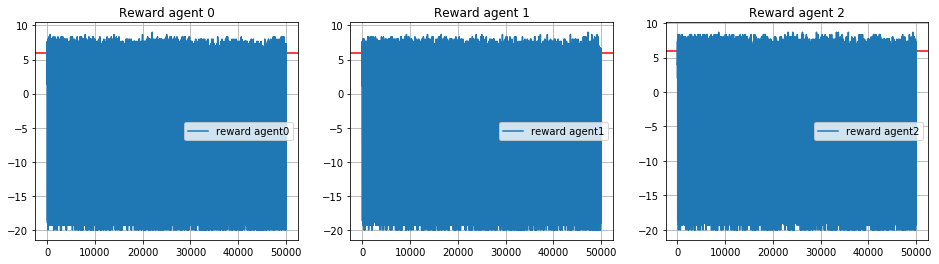

In [12]:
figure, ax = plt.subplots(1, n_players, figsize=(16, 4))

for i in range(n_players):
    ax[i].axhline(y=n_coins*multiplier/n_players, color='r', linestyle='-')
    ax[i].plot(np.linspace(0, n_episodes*episode_len, n_episodes*episode_len), agents1[i].memory.all_rewards, label='reward agent'+str(i))
    ax[i].legend()
    ax[i].grid()
    ax[i].set_title("Reward agent "+str(i))
plt.show()

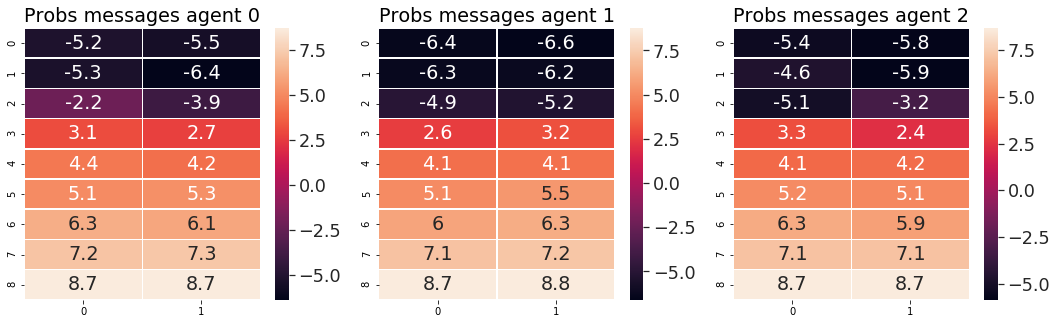

In [13]:
figure, ax = plt.subplots(1, 3, figsize=(18, 5))
sns.set(font_scale=1.6) 

for i in range(n_players):
    probbs = np.zeros((n_coins, 2))
    
    for c in range(n_coins):
        probbs[c] = agents1[i].comm_policy.q[c]
    
    sns.heatmap(probbs, annot=True, linewidth=.5,ax=ax[i])
    
    ax[i].set_title("Probs messages agent "+str(i))

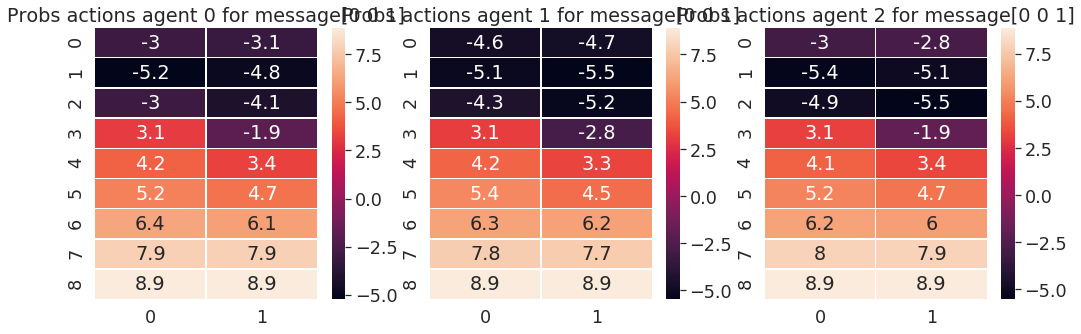

In [14]:
figure, ax = plt.subplots(1, 3, figsize=(17, 5))
message = np.array((0, 0, 1))

for i in range(n_players):
    probbs = np.zeros((n_coins, 2))
    
    for c in range(n_coins):
        probbs[c] = agents1[i].act_policy.q[c, np.sum(message)]
        
    sns.heatmap(probbs, annot=True, linewidth=.5, ax=ax[i])

    ax[i].set_title("Probs actions agent "+str(i)+" for message"+str(message))
    
plt.show()